In [1]:

import itertools
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')
import time

import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

### Verilerin Import Edilmesi

In [2]:
df = pd.read_csv('/Users/omergencayunlu/Desktop/DoğuşTeknoloji/DT_case_study_data.csv')


In [3]:

# date kolonunu datetime64 veri tipine dönüştürelim
df['date'] = pd.to_datetime(df['date'], utc=True)


#####################################################
# EDA
#####################################################

In [5]:

df["date"].min(), df["date"].max()


('2014-01-01', '2019-09-03')

- 2014 başından, 2019 9. ay başına kadar bir range var tarih açısından
- ilk tarihimiz 2014 yılında başlıyor

In [6]:

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(df)

##################### Shape #####################
(7708479, 9)
##################### Types #####################
part_number            int64
order_quantity       float64
date                  object
order_key              int64
order_key_line        object
supplied_quantity    float64
firm_explanation       int64
order_type            object
price                float64
dtype: object
##################### Head #####################
   part_number  order_quantity        date  order_key order_key_line  supplied_quantity  firm_explanation order_type   price
0            7             1.0  2014-01-01    1250047    1250047-001                1.0               109       Acil  220.49
1           22             1.0  2014-01-01     623232     623232-001                1.0                 1       Stok   13.56
2           29             3.0  2014-01-01     623232     623232-002                3.0                 1       Stok    3.65
3           43             1.0  2014-01-01    1226488    122648

- 7708479 adet gözlem, ve 9 adet değişken bulunuyor

- Değişkenlerde eksik değer bulunmamaktadır.
- Firm explantion aslında kategorik bir değişken, ancak numerik olarka ifade edildiği için int64 olarak dikkate alınmıştır.
- Part_number için de benzer şey söylenebilir. 
- Tanımlayıcı istatistiklerine bakıldığında, price da %5 lik ve %99 luk kesim arasında yüksek bir range var, buna benzer durum diğerlerinde de mevcut 

#### Outlier Kontrolü:

In [7]:


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [9]:
check_outlier(df,"order_quantity")

True

- Interquantile range yöntemiyle order quantity için outlier değer olup olmadığına bakıldığında, TRUE değer verdi.
- Order Quantity'de bu yöntemle outlier değer var gözüküyor.

#### Eksik Değer Kontrolü:

In [10]:


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [11]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


- Eksik değere sahip değişken tespit edilmemiştir.

#### Kaç Farklı Ürün Var?

In [13]:
df[["part_number"]].nunique()

part_number    2381
dtype: int64

- 2381 farklı ürün satıldığı görülmüştür.

#### Sipariş Dağılımı Nasıl?

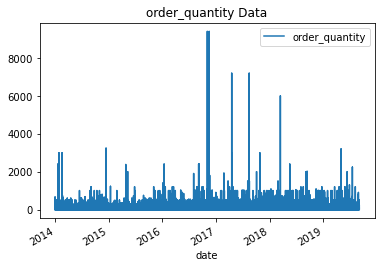

In [36]:
df_date= df.set_index('date')
df_date[['order_quantity']].plot(title='order_quantity Data')
plt.show();

- Order_quantity açısından bakıldığında, yıllar bazında ara ara  yükselmeler var, 
- Ancak şekil üzerinden anlaşılabildiği kadarıyla TREND yerine durağanlık söz konusu gibi, buna seriyi decompose ederek baktığımızda daha iyi karar verebiliriz
- En yüksek seviyeye 2017 yılında ulaşılmış olduğu görülmüştür.

#### Kaç Farklı Tedarikçi Var?

In [24]:
df[["firm_explanation"]].nunique()

firm_explanation    174
dtype: int64

- 174 farklı tedarikçi yer almaktadır veri setimizde.

#### Hangi YIlları Kapsıyor?

In [37]:
df_date.index.year.unique()


Int64Index([2014, 2015, 2016, 2017, 2018, 2019], dtype='int64', name='date')

- 2014,2015, 2016, 2017, 2018ve 2019 yıllarına ait siparişlere ilişkin verilere sahip olduğumuz görülmektedir.


#### Kaç farklı sipariş Tipi Var

In [38]:
df[["order_type"]].value_counts()

order_type
Stok          6118004
Acil          1590475
dtype: int64

- İki farklı sipariş tipi olduğu görülmektedir.
- Stok açıklaması ile yapılanların sayısının Acil açıklaması ile yapılanlardan fazla olduğu görülmüştür.


#### Bu tedarikçi kaç defa sipariş geçmişler?

In [39]:
df[["firm_explanation"]].value_counts()

firm_explanation
63                  318659
58                  288183
24                  267700
1                   233773
57                  232259
                     ...  
82                     231
139                     52
116                     34
23                       1
31                       1
Length: 174, dtype: int64

- En yüksek sipariş sayısı adet bazında 63 kodlu tedarikçi tarafından yapılmış
- En az sipariş ise 23 ve 31 kodlu tedarikçi tarafından yapılmış

###  Sipariş adedi toplamında en yüksek ve en düşük sipariş verilen 10 tedarikçi?

In [40]:
top_10_bayi=df.groupby(["firm_explanation"]).agg({'order_quantity':sum}).sort_values(by="order_quantity",ascending=False).head(10)
tail_10=df.groupby(["firm_explanation"]).agg({'order_quantity':sum}).sort_values(by="order_quantity",ascending=True).head(10)

###### En yüksek

In [41]:
top_10_bayi

,order_quantity
firm_explanation,
24,1879218.0
63,1679724.0
61,1523164.0
58,1485421.0
57,1335998.0
72,1188831.0
64,1138009.0
59,1133728.0
143,971779.0


- Tedarikçi bazlı order_quantity yani sipariş sayısına toplam bazlı baktığımızda 1.sırada 24 kodlu tedarikçinin yer aldığı görülmektedir.


##### En düşük

In [42]:
tail_10

,order_quantity
firm_explanation,
31,2.0
23,20.0
139,87.0
116,97.0
127,2019.0
82,2180.0
107,3041.0
165,3399.0
138,5115.0


- Altı yıllık dönem bazında totalde en düşük sipariş toplamına sahip tedarikçilere baktığımızda,
- Birinci sırada 31 kodlu tedarikçi 6 yılı i.inde sadece 2 defa sipariş vermiş gözüküyor


#####################################################
# FEATURE ENGINEERING
#####################################################


#####################################################
## Date Features
#####################################################


In [4]:

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df



In [5]:
df = create_date_features(df)


In [56]:
df.head()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,order_type,price,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,7,1.0,2014-01-01 00:00:00+00:00,1250047,1250047-001,1.0,109,Acil,220.49,1,1,1,1,3,2014,0,1,0
1,22,1.0,2014-01-01 00:00:00+00:00,623232,623232-001,1.0,1,Stok,13.56,1,1,1,1,3,2014,0,1,0
2,29,3.0,2014-01-01 00:00:00+00:00,623232,623232-002,3.0,1,Stok,3.65,1,1,1,1,3,2014,0,1,0
3,43,1.0,2014-01-01 00:00:00+00:00,1226488,1226488-001,1.0,157,Stok,8.82,1,1,1,1,3,2014,0,1,0
4,52,1.0,2014-01-01 00:00:00+00:00,1226488,1226488-143,1.0,157,Stok,38.72,1,1,1,1,3,2014,0,1,0


- Date değişkeninden yıl, ay, ayn günü, haftasonu olup olmaması, yılın haftası vb değerleri türettik.

### Tedarikçilerin Siparişlerinin Aylık Kırılımda İstatistikleri

In [57]:
df.groupby(["firm_explanation", "part_number", "month"]).agg({"order_quantity": ["sum", "mean", "median", "std"]})


order_quantity                            
                                              sum        mean median      std
firm_explanation part_number month                                           
0                0           5              100.0  100.000000  100.0      NaN
                             8              100.0  100.000000  100.0      NaN
                             12             200.0  100.000000  100.0  0.00000
                 5           7                1.0    1.000000    1.0      NaN
                 7           12               1.0    1.000000    1.0      NaN
...                                           ...         ...    ...      ...
173              2378        10               1.0    1.000000    1.0      NaN
                             11               5.0    1.666667    2.0  0.57735
                             12               6.0    1.500000    1.0  1.00000
                 2379        1              100.0  100.000000  100.0      NaN
                             5               10.0   10.000000   10.0      NaN

[1442786 rows x 4 columns]

- 0 kodlu tedarikçi, 

    -0 kodlu yedek parçayı
    
        -5.ayda 100 adet
        
        -8.ayda 100 adet
        
        -12.ayda 200 adet sipariş etmiş
        
        
    -5 kodlu yedek parçayı, sadece 7.ayda ve 1 adet sipariş etmiş
    
    -7 kodlu yedek parçayı 12.ayda ve 1 adet sipariş etmiş.
    
Bu vb bilgilere ulaştık.

### Ürün bazlı aylık kırılımda sipariş istatistkileri

In [86]:
df.groupby([ "part_number", "month"]).agg({"order_quantity": ["sum", "mean", "median", "std"]})


order_quantity                               
                             sum        mean median         std
part_number month                                              
0           1            39500.0  117.559524  100.0  115.207779
            2            54400.0  117.494600  100.0   90.552581
            3            77000.0  115.442279  100.0   85.870778
            4            58800.0  113.953488  100.0   59.439696
            5            66900.0  113.006757  100.0   70.168373
...                          ...         ...    ...         ...
2379        12            1339.0   10.543307   10.0   10.818676
2380        5               12.0    2.400000    2.0    1.516575
            6               17.0    3.400000    4.0    1.341641
            7               37.0    3.363636    4.0    1.566699
            8                9.0    3.000000    3.0    2.000000

[28361 rows x 4 columns]


#####################################################
## Random Noise
#####################################################

In [6]:

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))



#####################################################
## Lag/Shifted Features
#####################################################

#### Öncelikle sort edilmesi gerekir

In [7]:

df.sort_values(by=[ 'part_number', 'date'], axis=0, inplace=True)


In [88]:
df.head()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,order_type,price,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
416,0,100.0,2014-01-02 00:00:00+00:00,177874,177874-001,100.0,40,Stok,20.3,1,2,2,1,4,2014,0,0,0
417,0,100.0,2014-01-02 00:00:00+00:00,914190,914190-332,100.0,143,Stok,20.3,1,2,2,1,4,2014,0,0,0
418,0,100.0,2014-01-02 00:00:00+00:00,561468,561468-001,100.0,125,Stok,20.3,1,2,2,1,4,2014,0,0,0
6159,0,100.0,2014-01-03 00:00:00+00:00,1226506,1226506-002,100.0,157,Stok,20.3,1,3,3,1,5,2014,1,0,0
6160,0,100.0,2014-01-03 00:00:00+00:00,1275929,1275929-001,100.0,81,Stok,20.3,1,3,3,1,5,2014,1,0,0


- Bu sayede eklenecek lag değerleri, doğru şekilde gelecektir.

In [89]:
check_df(df)

##################### Shape #####################
(7708479, 18)
##################### Types #####################
part_number                        int64
order_quantity                   float64
date                 datetime64[ns, UTC]
order_key                          int64
order_key_line                    object
supplied_quantity                float64
firm_explanation                   int64
order_type                        object
price                            float64
month                              int64
day_of_month                       int64
day_of_year                        int64
week_of_year                       int64
day_of_week                        int64
year                               int64
is_wknd                            int64
is_month_start                     int64
is_month_end                       int64
dtype: object
##################### Head #####################
      part_number  order_quantity                      date  order_key order_key_line

- En son halinde df 7708479 gözlem ve 18 değişkenden oluşuyor.
- Eksik değer gözlenmemiştir.

In [8]:

def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby([ "part_number"])['order_quantity'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [9]:
df = lag_features(df, [7, 14, 21, 28, 35, 42, 49])


- Haftalık istediği için bu şekilde shift aralığı denedim.

In [92]:
df.tail(50)


,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,order_type,price,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_35,sales_lag_42,sales_lag_49
7628630,2379,10.0,2019-08-17 00:00:00+00:00,249425,249425-002,10.0,111,Acil,99.86,8,17,229,33,6,2019,1,0,0,9.489574,12.411645,8.926780,10.499557,8.366279,9.121973,10.371983
7634491,2379,10.0,2019-08-19 00:00:00+00:00,1512870,1512870-009,10.0,34,Acil,99.86,8,19,231,34,1,2019,0,0,0,12.820294,10.376881,10.515327,7.978059,7.444509,11.099543,99.751743
7634492,2379,10.0,2019-08-19 00:00:00+00:00,561164,561164-013,10.0,61,Acil,99.86,8,19,231,34,1,2019,0,0,0,98.807979,7.969829,20.217140,11.087556,19.314325,10.318483,13.143957
7641183,2379,10.0,2019-08-20 00:00:00+00:00,802104,802104-026,10.0,24,Acil,99.86,8,20,232,34,2,2019,0,0,0,8.707533,10.850850,8.427010,11.090167,9.961267,19.415403,11.080746
7641184,2379,10.0,2019-08-20 00:00:00+00:00,190246,190246-022,10.0,40,Acil,99.86,8,20,232,34,2,2019,0,0,0,8.700458,9.168964,12.911724,8.471845,11.815739,9.612233,52.203990
7641185,2379,10.0,2019-08-20 00:00:00+00:00,127995,127995-213,10.0,57,Stok,99.86,8,20,232,34,2,2019,0,0,0,9.792824,18.398498,7.587079,16.786933,10.950470,9.695734,10.690030
7641186,2379,10.0,2019-08-20 00:00:00+00:00,750194,750194-001,10.0,63,Acil,99.86,8,20,232,34,2,2019,0,0,0,30.784063,8.700558,8.997473,11.109104,10.071343,11.050247,12.066959
7641187,2379,10.0,2019-08-20 00:00:00+00:00,950418,950418-026,10.0,144,Acil,99.86,8,20,232,34,2,2019,0,0,0,9.192883,9.058921,8.912556,9.933631,13.235189,12.390719,11.158287
7648232,2379,10.0,2019-08-21 00:00:00+00:00,1462251,1462251-002,10.0,46,Acil,99.86,8,21,233,34,3,2019,0,0,0,7.998368,10.360849,10.124849,10.183067,9.834514,12.418264,11.645868
7648233,2379,10.0,2019-08-21 00:00:00+00:00,1103402,1103402-029,10.0,55,Acil,99.86,8,21,233,34,3,2019,0,0,0,8.000008,98.579144,9.608766,18.349733,11.515049,21.816148,11.422808



#####################################################
## Rolling Mean Features
#####################################################

#### Mantığı nasıl Çalışır? Kontrol Edelim

In [72]:

pd.DataFrame({"order_quantity": df["order_quantity"].values[0:10],
              "roll2": df["order_quantity"].rolling(window=2).mean().values[0:10],
              "roll3": df["order_quantity"].rolling(window=3).mean().values[0:10],
              "roll5": df["order_quantity"].rolling(window=5).mean().values[0:10]})

,order_quantity,roll2,roll3,roll5
0,100.0,NaN,NaN,NaN
1,100.0,100.0,NaN,NaN
2,100.0,100.0,100.0,NaN
3,100.0,100.0,100.0,NaN
4,1.0,50.5,67.0,80.2
5,1.0,1.0,34.0,60.4
6,1.0,1.0,1.0,40.6
7,1.0,1.0,1.0,20.8
8,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0


In [10]:

def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby([ "part_number"])['order_quantity']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [11]:
df = roll_mean_features(df, [365, 546])


In [12]:
df.head()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,order_type,price,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_35,sales_lag_42,sales_lag_49,sales_roll_mean_365,sales_roll_mean_546
416,0,100.0,2014-01-02 00:00:00+00:00,177874,177874-001,100.0,40,Stok,20.3,1,2,2,1,4,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,0,100.0,2014-01-02 00:00:00+00:00,914190,914190-332,100.0,143,Stok,20.3,1,2,2,1,4,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,0,100.0,2014-01-02 00:00:00+00:00,561468,561468-001,100.0,125,Stok,20.3,1,2,2,1,4,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6159,0,100.0,2014-01-03 00:00:00+00:00,1226506,1226506-002,100.0,157,Stok,20.3,1,3,3,1,5,2014,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6160,0,100.0,2014-01-03 00:00:00+00:00,1275929,1275929-001,100.0,81,Stok,20.3,1,3,3,1,5,2014,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 365 ve 546 değerlerini daha önce denediğim analizlerde daha tutarlı olduğunu gördüğüm için seçtim
- Bunlar yerine 7,9,14 vb değerler de verilebilir. o durumda da 7 günlük, 9 günlük hareketli ortalama hesaplaması yapılırdı
- Argumanlardan min_periods=10, min değer olarak belirledim, ancak default haliyle de bırakılabilirdir.
- Sonunda da hesaplanan hareketli ortalama değerlerine bir de noise ekledim

In [96]:
df.tail()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,order_type,price,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_35,sales_lag_42,sales_lag_49,sales_roll_mean_365,sales_roll_mean_546
7546989,2380,4.0,2019-07-26 00:00:00+00:00,931944,931944-007,4.0,143,Acil,6.58,7,26,207,30,5,2019,1,0,0,7.393775,1.251338,NaN,NaN,NaN,NaN,NaN,3.588490,1.255422
7550462,2380,4.0,2019-07-27 00:00:00+00:00,1315760,1315760-009,4.0,27,Stok,6.58,7,27,208,30,6,2019,1,0,0,-0.657738,5.426447,NaN,NaN,NaN,NaN,NaN,2.814233,5.922328
7604500,2380,3.0,2019-08-07 00:00:00+00:00,1315911,1315911-036,3.0,27,Stok,4.93,8,7,219,32,3,2019,0,0,0,0.077473,4.059969,3.873054,NaN,NaN,NaN,NaN,2.937472,0.679272
7610370,2380,1.0,2019-08-08 00:00:00+00:00,395330,395330-067,1.0,44,Stok,1.64,8,8,220,32,4,2019,0,0,0,6.652858,6.306829,2.250914,NaN,NaN,NaN,NaN,2.224740,-1.100242
7690809,2380,5.0,2019-08-29 00:00:00+00:00,283337,283337-013,5.0,78,Acil,8.22,8,29,241,35,4,2019,0,0,0,4.735571,4.910389,2.220618,NaN,NaN,NaN,NaN,3.914172,4.531476



#####################################################
## Exponentially Weighted Mean Features
#####################################################

#### Nasıl Çalıştığına Bir Bakalım.

In [77]:


pd.DataFrame({"order_quantity": df["order_quantity"].values[0:10],
              "roll2": df["order_quantity"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["order_quantity"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["order_quantity"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["order_quantity"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm01": df["order_quantity"].shift(1).ewm(alpha=0.1).mean().values[0:10]})



,order_quantity,roll2,ewm099,ewm095,ewm07,ewm01
0,100.0,NaN,NaN,NaN,NaN,NaN
1,100.0,NaN,100.000000,100.000000,100.000000,100.000000
2,100.0,100.0,100.000000,100.000000,100.000000,100.000000
3,100.0,100.0,100.000000,100.000000,100.000000,100.000000
4,1.0,100.0,100.000000,100.000000,100.000000,100.000000
5,1.0,50.5,1.990000,5.949971,30.531191,75.824766
6,1.0,1.0,1.009900,1.247498,9.844276,59.855643
7,1.0,1.0,1.000099,1.012375,3.651929,48.574199
8,1.0,1.0,1.000001,1.000619,1.795457,40.221001
9,1.0,1.0,1.000000,1.000031,1.238626,33.818404


- Exponential Weihted Mean ( ewm) ile hesaplanıyor.
- Bir shift alıp, sonrasında hesaplama yapmak gerekir.Bu nedenle roll2 şeklinde bir shift değerimiz var.
- alpha değeri: Geçmiş değerlere ne kadar önem vereceğimizi belirleyen bir katsayıdır. Burada farklı değerleri deniyoruz. En yakınlara daha önem vermek istersek 1 e yakın, geçmiş uzak değerlere önem vermek istersek 0 a yakın belirleriz.
- Hareketli ortalamada 100 +100 / 2 = 100 getirdi. 
- EWM De ise değeler 100 olduğu için farklı bir durum görülemeyebilir, ancak ewm099 da yakın değere daha önem verildiği için 100 ile 102 olsaydı durum farklı çıkacaktı.

#### Fonksiyonlaştıralım

In [12]:

def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby([ "part_number"])['order_quantity']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


- Bu fonksiyon ile hem ağırlıklı ortalamaya göre hem de lag'lara göre değer üretilereki olası kombinasyonlara karşılık gelen değerler atanacaktır.
- String yapısı ile de yeni değişken isminde ilgili alpha ve lag deperi yer alacaktır.

#### Aday Alpha ve Lag değerleri

In [13]:
lags= [7, 14, 21, 28, 35, 42, 49]
alphas= [0.95,0.9,0.8,0.7,0.5]

#### Hesaplayıp, yeni df atayalım

In [14]:
df= ewm_features(df,alphas,lags)

In [16]:
df.head()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,order_type,price,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_35,sales_lag_42,sales_lag_49,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_21,sales_ewm_alpha_095_lag_28,sales_ewm_alpha_095_lag_35,sales_ewm_alpha_095_lag_42,sales_ewm_alpha_095_lag_49,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_21,sales_ewm_alpha_09_lag_28,sales_ewm_alpha_09_lag_35,sales_ewm_alpha_09_lag_42,sales_ewm_alpha_09_lag_49,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_21,sales_ewm_alpha_08_lag_28,sales_ewm_alpha_08_lag_35,sales_ewm_alpha_08_lag_42,sales_ewm_alpha_08_lag_49,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_21,sales_ewm_alpha_07_lag_28,sales_ewm_alpha_07_lag_35,sales_ewm_alpha_07_lag_42,sales_ewm_alpha_07_lag_49,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_21,sales_ewm_alpha_05_lag_28,sales_ewm_alpha_05_lag_35,sales_ewm_alpha_05_lag_42,sales_ewm_alpha_05_lag_49
416,0,100.0,2014-01-02 00:00:00+00:00,177874,177874-001,100.0,40,Stok,20.3,1,2,2,1,4,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,0,100.0,2014-01-02 00:00:00+00:00,914190,914190-332,100.0,143,Stok,20.3,1,2,2,1,4,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,0,100.0,2014-01-02 00:00:00+00:00,561468,561468-001,100.0,125,Stok,20.3,1,2,2,1,4,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6159,0,100.0,2014-01-03 00:00:00+00:00,1226506,1226506-002,100.0,157,Stok,20.3,1,3,3,1,5,2014,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6160,0,100.0,2014-01-03 00:00:00+00:00,1275929,1275929-001,100.0,81,Stok,20.3,1,3,3,1,5,2014,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Yeni df veri setimizde, sales_ewm_alpha_07_lag_7,sales_ewm_alpha_09_lag_28 gibi değişkenler türetildi.
- ilk sayı alpha değerini, ikinci sayı ise lag değerini göstermektedir.
- Totalde 62 adet değişkene sahip olduk

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7708479 entries, 416 to 7690809
Data columns (total 62 columns):
 #   Column                      Dtype              
---  ------                      -----              
 0   part_number                 int64              
 1   order_quantity              float64            
 2   date                        datetime64[ns, UTC]
 3   order_key                   int64              
 4   order_key_line              object             
 5   supplied_quantity           float64            
 6   firm_explanation            int64              
 7   order_type                  object             
 8   price                       float64            
 9   month                       int64              
 10  day_of_month                int64              
 11  day_of_year                 int64              
 12  week_of_year                int64              
 13  day_of_week                 int64              
 14  year                        int6


#####################################################
## One-Hot Encoding
#####################################################



In [15]:
df = pd.get_dummies(df, columns=['day_of_week', 'month', 'is_month_start', 'is_month_end',"order_type"])


- 'day_of_week', 'month', 'is_month_start', 'is_month_end' ve "order_type" bu değişkenleri OHE yapma kararı verdim. 
- Part Number ya da firm_explanation ya da day of year vb değerleri de yapabiliriz. Ancak çok fazla değişken üretilmiş olacağı için sadece yukarıdaki değişkenleri tercih ettim.Diğerleri zaten sayısal değer. Bunun üzerine düşünülebilir ve farklı denemeler yapılabilir.
- OHE dönüşümü için de pandas get_dummies fonksiyonunu kullandım. Scikit-learn deki yapı da tercih edilebilirdi. Ancak o fonksiyonu daha production seviyesinde tercih edebiliriz. 

In [18]:
df.shape

(7708479, 82)

- OHE sonrası değişken sayısı 82'ye yükseldi. 
- Object veri tipinde kalan tek değişken order_key_line değişkeni

#### Order Key Line' a bakalım

In [21]:
df[["order_key_line"]].nunique()

order_key_line    7706541
dtype: int64

- 7706541 adet unique değere sahip. Açıklaması da Siparişe Özgü Anahtar Numaraları olduğu için modelde kullanmaya gerek duyulmamıştır.

In [16]:
df_last= df.drop(["order_key_line"], axis=1)

In [24]:
df_last.head()

,part_number,order_quantity,date,order_key,supplied_quantity,firm_explanation,price,day_of_month,day_of_year,week_of_year,year,is_wknd,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_35,sales_lag_42,sales_lag_49,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_21,sales_ewm_alpha_095_lag_28,sales_ewm_alpha_095_lag_35,sales_ewm_alpha_095_lag_42,sales_ewm_alpha_095_lag_49,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_21,sales_ewm_alpha_09_lag_28,sales_ewm_alpha_09_lag_35,sales_ewm_alpha_09_lag_42,sales_ewm_alpha_09_lag_49,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_21,sales_ewm_alpha_08_lag_28,sales_ewm_alpha_08_lag_35,sales_ewm_alpha_08_lag_42,sales_ewm_alpha_08_lag_49,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_21,sales_ewm_alpha_07_lag_28,sales_ewm_alpha_07_lag_35,sales_ewm_alpha_07_lag_42,sales_ewm_alpha_07_lag_49,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_21,sales_ewm_alpha_05_lag_28,sales_ewm_alpha_05_lag_35,sales_ewm_alpha_05_lag_42,sales_ewm_alpha_05_lag_49,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_month_start_0,is_month_start_1,is_month_end_0,is_month_end_1,order_type_Acil,order_type_Stok
416,0,100.0,2014-01-02 00:00:00+00:00,177874,100.0,40,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
417,0,100.0,2014-01-02 00:00:00+00:00,914190,100.0,143,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
418,0,100.0,2014-01-02 00:00:00+00:00,561468,100.0,125,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
6159,0,100.0,2014-01-03 00:00:00+00:00,1226506,100.0,157,20.3,3,3,1,2014,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
6160,0,100.0,2014-01-03 00:00:00+00:00,1275929,100.0,81,20.3,3,3,1,2014,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1



#####################################################
## Converting order_quantity to log(1+sales)
#####################################################



#### order quantity dağılımına bakalım

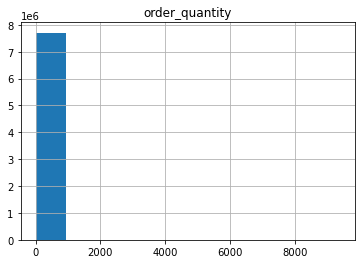

In [25]:
df[["order_quantity"]].hist();

#### Normal Dağılıma benzemediği ve sola çarpık bir yapıda olduğundan, log dönüşüm yapmaya karar verdim

In [16]:
df['order_quantity'] = np.log1p(df["order_quantity"].values)

- Bir regresyon problemi olan case'de, bağımlı değişkeni değiştirip değiştirmemek tercihe bağlı
- Ancak dönüşüm yapılmasıyla gradient desccent uygulanacağı zaman iterasyon sayısının artmasının önüne geçilebilir.

#### Dağılımına tekrar bakalım

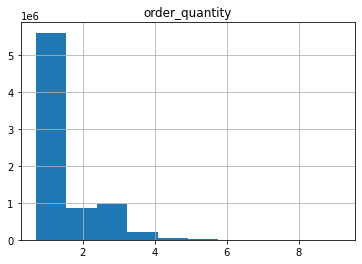

In [27]:
df[["order_quantity"]].hist();

#### Öncekine göre daha iyi denilebilecek bir dağılıma sahip oldu.

#### Verinin model öncesi halini kaydedilmesi

In [17]:
df.head()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,price,day_of_month,day_of_year,week_of_year,year,is_wknd,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_35,sales_lag_42,sales_lag_49,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_21,sales_ewm_alpha_095_lag_28,sales_ewm_alpha_095_lag_35,sales_ewm_alpha_095_lag_42,sales_ewm_alpha_095_lag_49,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_21,sales_ewm_alpha_09_lag_28,sales_ewm_alpha_09_lag_35,sales_ewm_alpha_09_lag_42,sales_ewm_alpha_09_lag_49,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_21,sales_ewm_alpha_08_lag_28,sales_ewm_alpha_08_lag_35,sales_ewm_alpha_08_lag_42,sales_ewm_alpha_08_lag_49,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_21,sales_ewm_alpha_07_lag_28,sales_ewm_alpha_07_lag_35,sales_ewm_alpha_07_lag_42,sales_ewm_alpha_07_lag_49,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_21,sales_ewm_alpha_05_lag_28,sales_ewm_alpha_05_lag_35,sales_ewm_alpha_05_lag_42,sales_ewm_alpha_05_lag_49,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_month_start_0,is_month_start_1,is_month_end_0,is_month_end_1,order_type_Acil,order_type_Stok
416,0,4.615121,2014-01-02 00:00:00+00:00,177874,177874-001,100.0,40,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
417,0,4.615121,2014-01-02 00:00:00+00:00,914190,914190-332,100.0,143,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
418,0,4.615121,2014-01-02 00:00:00+00:00,561468,561468-001,100.0,125,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
6159,0,4.615121,2014-01-03 00:00:00+00:00,1226506,1226506-002,100.0,157,20.3,3,3,1,2014,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
6160,0,4.615121,2014-01-03 00:00:00+00:00,1275929,1275929-001,100.0,81,20.3,3,3,1,2014,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1


In [18]:
!pwd

/Users/omergencayunlu/Desktop/DoğuşTeknoloji


In [21]:
import pickle
df.to_pickle("/Users/omergencayunlu/Desktop/DoğuşTeknoloji/prep_model.pkl")

#### Daha sonraki çağırmalar için fonksiyon hazırlanması

In [2]:
def load_df():
    df = pd.read_pickle("/Users/omergencayunlu/Desktop/DoğuşTeknoloji/prep_model.pkl")
     
    return df


In [3]:
df= load_df()
df.head()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,price,day_of_month,day_of_year,week_of_year,year,is_wknd,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_35,sales_lag_42,sales_lag_49,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_21,sales_ewm_alpha_095_lag_28,sales_ewm_alpha_095_lag_35,sales_ewm_alpha_095_lag_42,sales_ewm_alpha_095_lag_49,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_21,sales_ewm_alpha_09_lag_28,sales_ewm_alpha_09_lag_35,sales_ewm_alpha_09_lag_42,sales_ewm_alpha_09_lag_49,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_21,sales_ewm_alpha_08_lag_28,sales_ewm_alpha_08_lag_35,sales_ewm_alpha_08_lag_42,sales_ewm_alpha_08_lag_49,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_21,sales_ewm_alpha_07_lag_28,sales_ewm_alpha_07_lag_35,sales_ewm_alpha_07_lag_42,sales_ewm_alpha_07_lag_49,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_21,sales_ewm_alpha_05_lag_28,sales_ewm_alpha_05_lag_35,sales_ewm_alpha_05_lag_42,sales_ewm_alpha_05_lag_49,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_month_start_0,is_month_start_1,is_month_end_0,is_month_end_1,order_type_Acil,order_type_Stok
416,0,4.615121,2014-01-02 00:00:00+00:00,177874,177874-001,100.0,40,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
417,0,4.615121,2014-01-02 00:00:00+00:00,914190,914190-332,100.0,143,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
418,0,4.615121,2014-01-02 00:00:00+00:00,561468,561468-001,100.0,125,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
6159,0,4.615121,2014-01-03 00:00:00+00:00,1226506,1226506-002,100.0,157,20.3,3,3,1,2014,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
6160,0,4.615121,2014-01-03 00:00:00+00:00,1275929,1275929-001,100.0,81,20.3,3,3,1,2014,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1



#####################################################
# Custom Cost Function
#####################################################

In [18]:




def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

- 
 MAE: mean absolute error
 MAPE: mean absolute percentage error
 SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
 fonksiyonları modeli değerlendirmek için kullanılabilir. Ancak ben bu modelde SMAPE'yi kullanma kararı aldım.
 
 
- Model train ve test aşamasında, overfitting sıklıkla rastlanan bir durum 
- Bunun önüne geçmek adına çatallaşmanın başladığı yerde early stopping yapmak istiyorum,
- Ancak buna karar verirken de nerede durmam gerektiğine yönelik farklı alternatiflerden de görüş almak istiyorum 



- Ayrıca smape'nin lgbm'e uyarlanmış halinde, yukarıda log dönüşüm yaptığım için, expm1 ile geri dönüştürme işlemi yaparak, hata metriğini hesaplayacak

Bu fonksiyon bu ihtiyaçlarımı karşılayacaktır.


#####################################################
# MODEL VALIDATION
#####################################################

#### Light GBM: optimizasyon 2 açıdan ele alınmalı.
- Derinlik, yaprak vb ne olacak? ( Hiperparametre optimizasyonu)
- iterasyon sayısı 


Örneğin iterasyon sayısını 10 bin belirleyip, olası Hiperparametreler arasından seçim yapıp, bu sefer iterasyon sayısı kaç olmalıyı aramak şeklinde bir yaklaşım kastedilmektedir.


#####################################################
## Time-Based Validation Sets
#####################################################

Yani validasyon setini nasıl belirleyeceğiz?

- Bir zaman serisi üzerinde çalıştığımız için, klasik train test split yaklaşımı ile bölersek, muhtemelen yanlış sonuçlar elde edeceğimiz için, validasyon setini zaman ayarlı yapma kararı aldım
- Benden beklenen 2019-09-04 .... 2019-10-23 dönemine ilişkin tahmin olduğu için 2018 in aynı dönemini validasyon olarak seçmeye karar verdim. Aynı şekilde 2017 yılını da test veri seti  olarak belirledim

#### Train setini belirleyelim

In [4]:
train = df.loc[(df["date"] < "2018-01-01"), :]
train["date"].min(), train["date"].max()

(Timestamp('2014-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2017-12-31 00:00:00+0000', tz='UTC'))

#### Test setini belirleyelim

In [5]:
test = df.loc[(df["date"] >= "2018-01-01")&(df["date"] < "2018-09-04"),:]

In [41]:
test["date"].min(), test["date"].max()

(Timestamp('2018-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2018-09-03 00:00:00+0000', tz='UTC'))

#### Val setini belirleyelim

In [6]:

# 2018'nin ilk ilgili haftaları validasyon seti.
val = df.loc[(df["date"] >= "2018-09-04") & (df["date"] <= "2018-10-23"), :]

In [36]:
val["date"].min(), val["date"].max()

(Timestamp('2018-09-04 00:00:00+0000', tz='UTC'),
 Timestamp('2018-10-23 00:00:00+0000', tz='UTC'))

#### Bağımlı ve Bağımsız Değişkenlerin Seçilmesi

In [43]:
df.columns

Index(['part_number', 'order_quantity', 'date', 'order_key', 'order_key_line', 'supplied_quantity', 'firm_explanation', 'price', 'day_of_month', 'day_of_year', 'week_of_year', 'year', 'is_wknd', 'sales_lag_7', 'sales_lag_14', 'sales_lag_21', 'sales_lag_28', 'sales_lag_35', 'sales_lag_42', 'sales_lag_49', 'sales_roll_mean_365', 'sales_roll_mean_546', 'sales_ewm_alpha_095_lag_7', 'sales_ewm_alpha_095_lag_14', 'sales_ewm_alpha_095_lag_21', 'sales_ewm_alpha_095_lag_28',
       'sales_ewm_alpha_095_lag_35', 'sales_ewm_alpha_095_lag_42', 'sales_ewm_alpha_095_lag_49', 'sales_ewm_alpha_09_lag_7', 'sales_ewm_alpha_09_lag_14', 'sales_ewm_alpha_09_lag_21', 'sales_ewm_alpha_09_lag_28', 'sales_ewm_alpha_09_lag_35', 'sales_ewm_alpha_09_lag_42', 'sales_ewm_alpha_09_lag_49', 'sales_ewm_alpha_08_lag_7', 'sales_ewm_alpha_08_lag_14', 'sales_ewm_alpha_08_lag_21', 'sales_ewm_alpha_08_lag_28', 'sales_ewm_alpha_08_lag_35', 'sales_ewm_alpha_08_lag_42',
       'sales_ewm_alpha_08_lag_49', 'sales_ewm_alpha_07_l

- Bağımsız değişkenlerin belirlenmesi

In [8]:

cols = [col for col in train.columns if col not in ['date', 'order_key', "order_quantity", "year","order_key_line","supplied_quantity","firm_explanation","price"]]


- date zaten veride bölerken kullandım
- order_ley unique bir değer anlam ifade etmediğini düşündüm
- order_quantity bağımlı değişkenimiz
- year ı da çıkarmaya karar verdim
- Aynı şekilde price ve firm explanation'u da modelden çıkarıyorum

In [47]:
# Bağımsız değişkenler
cols

['part_number',
 'day_of_month',
 'day_of_year',
 'week_of_year',
 'is_wknd',
 'sales_lag_7',
 'sales_lag_14',
 'sales_lag_21',
 'sales_lag_28',
 'sales_lag_35',
 'sales_lag_42',
 'sales_lag_49',
 'sales_roll_mean_365',
 'sales_roll_mean_546',
 'sales_ewm_alpha_095_lag_7',
 'sales_ewm_alpha_095_lag_14',
 'sales_ewm_alpha_095_lag_21',
 'sales_ewm_alpha_095_lag_28',
 'sales_ewm_alpha_095_lag_35',
 'sales_ewm_alpha_095_lag_42',
 'sales_ewm_alpha_095_lag_49',
 'sales_ewm_alpha_09_lag_7',
 'sales_ewm_alpha_09_lag_14',
 'sales_ewm_alpha_09_lag_21',
 'sales_ewm_alpha_09_lag_28',
 'sales_ewm_alpha_09_lag_35',
 'sales_ewm_alpha_09_lag_42',
 'sales_ewm_alpha_09_lag_49',
 'sales_ewm_alpha_08_lag_7',
 'sales_ewm_alpha_08_lag_14',
 'sales_ewm_alpha_08_lag_21',
 'sales_ewm_alpha_08_lag_28',
 'sales_ewm_alpha_08_lag_35',
 'sales_ewm_alpha_08_lag_42',
 'sales_ewm_alpha_08_lag_49',
 'sales_ewm_alpha_07_lag_7',
 'sales_ewm_alpha_07_lag_14',
 'sales_ewm_alpha_07_lag_21',
 'sales_ewm_alpha_07_lag_28',
 's

#### Train  ve Validasyon setini bağımlı ve bağımsız değişkenlerine ayırma

In [23]:

Y_train = train['order_quantity']
X_train = train[cols]

Y_val = val['order_quantity']
X_val = val[cols]

In [49]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((5009098,), (5009098, 74), (233140,), (233140, 74))


#####################################################
## 1- LightGBM Model
#####################################################

#### a- Hiperparametre Tuning

- Base Model Kurulması

#from lightgbm import LGBMRegressor
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


lgbm = LGBMRegressor(random_state=12345)

lgbm.fit(X_train, Y_train)
y_pred = lgbm.predict(X_val)
acc = accuracy_score(Y_val, y_pred)

print(acc)


 - Hiperparametre Tuning


lgbm_params = {"learning_rate": [0.01, 0.1, 0.5],
               "n_estimators": [500, 1000, 1500],
               "max_depth": [3, 5, 8]} # vb tune edilecek değerler artırılabilir.

gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv=5,
                     n_jobs=-1,
                     verbose=2).fit(X, y)
print(**gs_cv.best_params_)

lgbm_tuned = LGBMRegressor(**gs_cv.best_params_).fit(X_train, Y_train)
cross_val_score(lgbm_tuned, X_train, Y_train, cv=10).mean()

In [24]:

# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [25]:

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)


y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.816660 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.279808	training's SMAPE: 38.8832	valid_1's l1: 0.293369	valid_1's SMAPE: 40.1724
[200]	training's l1: 0.253246	training's SMAPE: 34.4426	valid_1's l1: 0.266803	valid_1's SMAPE: 35.5115
[300]	training's l1: 0.250389	training's SMAPE: 33.833	valid_1's l1: 0.263647	valid_1's SMAPE: 34.823
[400]	training's l1: 0.249663	training's SMAPE: 33.6861	valid_1's l1: 0.262933	valid_1's SMAPE: 34.677
[500]	training's l1: 0.249443	training's SMAPE: 33.6525	valid_1's l1: 0.262693	valid_1's SMAPE: 34.65
[600]	training's l1: 0.249285	training's SMAPE: 33.6335	valid_1's l1: 0.262403	valid_1's SMAPE: 34.6213
[700]	training's l1: 0.249165	training's SMAPE: 33.6169	valid_1's l1: 0.262203	valid_1's SMAPE: 34.598
[800]	training's l1: 0.249072	training's SMAPE: 33.

34.550618585148904

- Her 100 iterasyonda raporlayacak şekilde ayarladım 
- 200 iterasyon sonrasında değişim yoksa earl-stopping yapacak
- l1 olarak gözüken metric aslında mae, SMAPE de yukarıda açıkladım
- 1.iterasyon sonucunda mae ve SMAPE düşmüş, bunu görebiliyoruz.(Hem Train hem validasyonda)
- Devam eden iterasyonlarda küsuratlar şeklinde de olsa düşmeler devam etmiş ve early stopping devreye girmesini gerektiren bir durum yaşanmamış. İterasyon sayısını artırak düşmeye devam edebilir.  Ancak local bilgisayarımda ne yazık ki kapasite yetersiz kaldı.
- Hali hazırda best iterasyon 1000. iterasyon olarak tespit edilmiştir.
- Best itreasyon da belirlenmiş oldu

In [26]:

# save the model
import pickle
pickle.dump(model, open("model.pkl", "wb"))


- Notebook'u her açtığımızda tekrar tekrar model kurmak yerine modeli pkl olarak kaydetmeyi tercih ettim

In [11]:
import pickle
# load the model
model = pickle.load(open("model.pkl", "rb"))


#### Best İterasyonu Modele Ekleyelim

In [29]:
model.best_iteration=1000

In [28]:
y_pred_val = model.predict(X_val, num_iteration=1000)


In [65]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))


34.55648335570262

- expm1 ile logaritmik dönüşümün tersini alıyoruz.
-Yüzdelik cinsten modelimizin validasyon hata oranı %34 olarak tespit edilmiştir.

##########################################
## Değişken önem düzeyleri
##########################################

In [66]:


def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)

                       feature  split       gain
12         sales_roll_mean_365    717  36.896834
13         sales_roll_mean_546    638  29.611263
42    sales_ewm_alpha_05_lag_7    612   9.495676
43   sales_ewm_alpha_05_lag_14    389   7.356437
44   sales_ewm_alpha_05_lag_21    255   4.842432
45   sales_ewm_alpha_05_lag_28    258   3.694206
46   sales_ewm_alpha_05_lag_35    273   2.762479
47   sales_ewm_alpha_05_lag_42    213   2.132479
48   sales_ewm_alpha_05_lag_49    370   1.515300
22   sales_ewm_alpha_09_lag_14    119   0.130325
35    sales_ewm_alpha_07_lag_7    182   0.125295
14   sales_ewm_alpha_095_lag_7    214   0.120832
28    sales_ewm_alpha_08_lag_7    151   0.110274
18  sales_ewm_alpha_095_lag_35    156   0.104613
19  sales_ewm_alpha_095_lag_42    140   0.086856
23   sales_ewm_alpha_09_lag_21     90   0.085100
0                  part_number    688   0.082976
20  sales_ewm_alpha_095_lag_49    146   0.074416
16  sales_ewm_alpha_095_lag_21    166   0.067379
37   sales_ewm_alpha

- split: ilgili değişkenin modelleme sürecinde kaç kere split edildiğini göstermektedir.
- gain: featue ilişkin bölmeden önce ve sonrasındaki entropi değişimini ifade eder.Yani en çok kazancı, en çok entropi değişimi sağlayan feature sağlar şeklinde düşünebiliriz.Entropiyi ne kadar azalttı şeklinde de düşünebiliriz.

- sales_roll_mean_365: değişkeni en çok split edilen ve en entropiyi en çok azaltan değişken olarak karşımıza çıkmıştır.
- sales_ewm_alpha_05_lag_7: aloha değeri 0.5 olan yani  uzak geçmişe odaklanılmış ve  lag değeri 7 gün olan değişken 3.sırada yer almıştır.
- order_type_Acil olanlar 342 kez split edilmiş, gaini ise 0.05. Yani oldukça düşük.
- laglerdeki 7,35,28,42 çok doğru bir tercih olmamış gibi gözüküyor.
- Monthlara ilişkin bir pattern olur diye düşünmekteydim model EDA ve preprocees aşamasında, ancak burada ne yazık ki rastlamadım.



#### Görselleştirecek olursak:

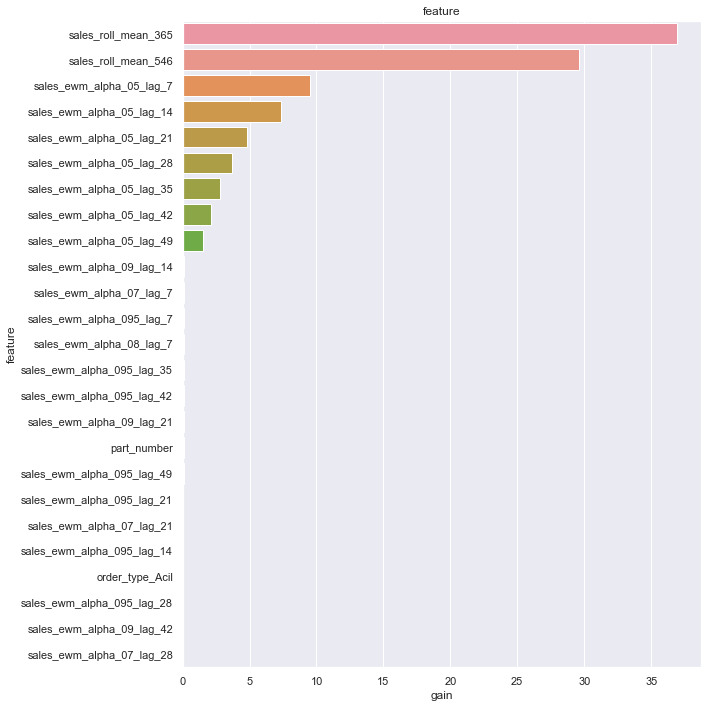

In [67]:

plot_lgb_importances(model, plot=True, num=30)


#### Test setinde bakalım 

In [70]:

Y_test = test['order_quantity']
X_test = test[cols]

In [71]:
y_pred_val = model.predict(X_test, num_iteration=model.best_iteration)


smape(np.expm1(y_pred_val), np.expm1(Y_test))


35.867582381352946

- Modeli validasyon sürecine soktuğum için test verisi açısından hiç görmediği veri setinde de yakın bir SMAPE hata yüzdesi verdi
- Yüzdelik cinsten modelimizin test hata oranı %35 olarak tespit edilmiştir.

### 2019-09-04 .... 2019-10-23 içinde tahminde bulunulması

#### Forecast istenen dönemin bir önceki yılının tahmini

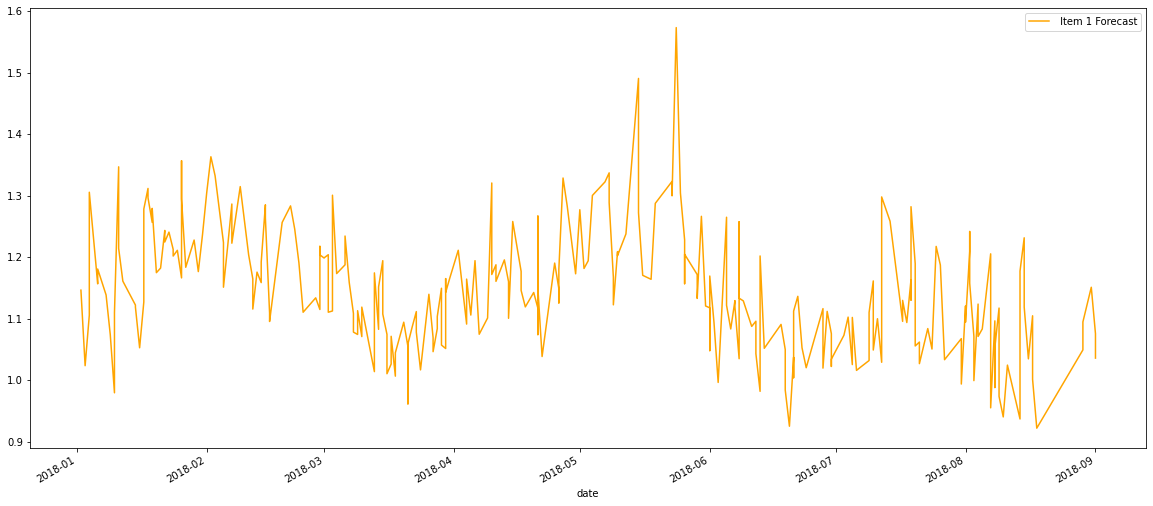

In [12]:
test_final = df.loc[(df["date"] >= "2018-01-01")&(df["date"] < "2018-09-04"),:]
X_test_final = test_final[cols]
forecast = pd.DataFrame({
    "date":test_final.date,
    "part_number":test_final.part_number,
    
    "order_quantity":model.predict(X_test_final,num_iteration=model.best_iteration)
})



forecast[(forecast.part_number == 1)].set_index("date").order_quantity.plot(color = "orange", figsize = (20,9),legend=True, label = " Item 1 Forecast");

In [43]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1107549 entries, 5009098 to 6116646
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype              
---  ------          --------------    -----              
 0   date            1107549 non-null  datetime64[ns, UTC]
 1   part_number     1107549 non-null  int64              
 2   order_quantity  1107549 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 33.8 MB


In [13]:
test_final['date2'] = pd.DatetimeIndex( test_final['date'] ) + pd.DateOffset(years = 1)

In [169]:
test_final.head()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,price,day_of_month,day_of_year,week_of_year,year,is_wknd,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_35,sales_lag_42,sales_lag_49,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_21,sales_ewm_alpha_095_lag_28,sales_ewm_alpha_095_lag_35,sales_ewm_alpha_095_lag_42,sales_ewm_alpha_095_lag_49,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_21,sales_ewm_alpha_09_lag_28,sales_ewm_alpha_09_lag_35,sales_ewm_alpha_09_lag_42,sales_ewm_alpha_09_lag_49,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_21,sales_ewm_alpha_08_lag_28,sales_ewm_alpha_08_lag_35,sales_ewm_alpha_08_lag_42,sales_ewm_alpha_08_lag_49,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_21,sales_ewm_alpha_07_lag_28,sales_ewm_alpha_07_lag_35,sales_ewm_alpha_07_lag_42,sales_ewm_alpha_07_lag_49,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_21,sales_ewm_alpha_05_lag_28,sales_ewm_alpha_05_lag_35,sales_ewm_alpha_05_lag_42,sales_ewm_alpha_05_lag_49,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_month_start_0,is_month_start_1,is_month_end_0,is_month_end_1,order_type_Acil,order_type_Stok,date2
5009098,0,5.303305,2018-01-01 00:00:00+00:00,258211,258211-002,200.0,123,83.21,1,1,1,2018,0,100.684076,101.935542,99.549552,100.197838,102.806046,100.228590,97.446595,137.077747,133.876215,100.237530,100.011875,100.0,100.0,100.000004,109.500000,100.011878,100.900900,100.090000,100.0,100.0,100.000272,118.0000,100.090180,103.225608,100.640000,100.0,100.0,100.015770,132.000008,100.650248,106.470513,101.890000,100.0,100.000035,100.162275,142.000436,101.992473,114.111328,106.250001,100.000167,100.021366,102.734855,150.061417,107.861382,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,2019-01-01 00:00:00+00:00
5009782,0,4.615121,2018-01-02 00:00:00+00:00,172676,172676-001,100.0,7,41.61,2,2,1,2018,0,100.938801,100.736341,98.411485,102.015346,99.492510,397.711857,102.068370,136.939360,131.426331,100.011876,100.000594,100.0,100.0,100.000000,385.475000,100.000594,100.090090,100.009000,100.0,100.0,100.000027,371.8000,100.009018,100.645122,100.128000,100.0,100.0,100.003154,346.400002,100.130050,101.941154,100.567000,100.0,100.000011,100.048683,322.600131,100.597742,107.055664,103.125001,100.000083,100.010683,101.367427,275.030709,103.930691,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,2019-01-02 00:00:00+00:00
5009783,0,4.615121,2018-01-02 00:00:00+00:00,1308032,1308032-001,100.0,27,41.61,2,2,1,2018,0,203.454178,197.652204,100.422802,99.934832,100.467198,101.589068,100.636916,133.830466,132.159222,195.000594,195.000030,100.0,100.0,100.000000,114.273750,100.000030,190.009009,190.000900,100.0,100.0,100.000003,127.1800,100.000902,180.129024,180.025600,100.0,100.0,100.000631,149.280000,100.026010,170.582346,170.170100,100.0,100.000003,100.014605,166.780039,100.179323,153.527832,151.562500,100.000042,100.005342,100.683714,187.515354,101.965346,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,2019-01-02 00:00:00+00:00
5009784,0,5.303305,2018-01-02 00:00:00+00:00,1368553,1368553-003,200.0,49,83.21,2,2,1,2018,0,97.772566,102.097123,95.975897,102.984482,100.800627,100.520367,100.440598,133.874999,133.811762,104.750030,104.750001,100.0,100.0,100.000000,100.713688,100.000001,109.000901,109.000090,100.0,100.0,100.000000,102.7180,100.000090,116.025805,116.005120,100.0,100.0,100.000126,109.856000,100.005202,121.174704,121.051030,100.0,100.000001,100.004381,120.034012,100.053797,126.763916,125.781250,100.000021,100.002671,100.341857,143.757677,100.982673,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,2019-01-02 00:00:00+00:00
5009785,0,4.615121,2018-01-02 00:00:00+00:00,114125,1141

In [200]:
test_final[["date","date2"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1107549 entries, 5009098 to 6116646
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype              
---  ------  --------------    -----              
 0   date    1107549 non-null  datetime64[ns, UTC]
 1   date2   1107549 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2)
memory usage: 57.6 MB


### 2019-09-04 .... 2019-10-23 içinde tahminlerinin haftalık hale getirilmesi

In [14]:
forecast = pd.DataFrame({
    "date":test_final.date2,
    "part_number":test_final.part_number,
    
    "order_quantity":model.predict(X_test_final,num_iteration=model.best_iteration)
})

In [122]:
forecast.head()

,date,part_number,order_quantity
5009098,2019-01-01 00:00:00+00:00,0,4.775376
5009782,2019-01-02 00:00:00+00:00,0,4.732382
5009783,2019-01-02 00:00:00+00:00,0,4.748277
5009784,2019-01-02 00:00:00+00:00,0,4.748277
5009785,2019-01-02 00:00:00+00:00,0,4.752383


#### Order quantity de logaritmik dönüşüm yaptığım için şimdi üssel dönüşüm yaparak eski haline getiriyorum.

In [18]:
forecast["order_quantity"]= np.expm1(forecast["order_quantity"])

In [113]:
#forecast.set_index(['date','part_number'], inplace=True)

In [19]:
forecast.set_index('date', drop=True, inplace=True)


In [20]:
forecast.head()

,part_number,order_quantity
date,,
2019-01-01 00:00:00+00:00,0,117.554878
2019-01-02 00:00:00+00:00,0,112.565737
2019-01-02 00:00:00+00:00,0,114.385333
2019-01-02 00:00:00+00:00,0,114.385333
2019-01-02 00:00:00+00:00,0,114.860046


In [21]:
result= forecast.groupby("part_number").resample('W-Wed').sum()

In [22]:
result.head()

part_number  order_quantity
part_number date                                                  
0           2019-01-02 00:00:00+00:00            0      573.751329
            2019-01-09 00:00:00+00:00            0     1080.561923
            2019-01-16 00:00:00+00:00            0     2092.864826
            2019-01-23 00:00:00+00:00            0     1726.490468
            2019-01-30 00:00:00+00:00            0     1758.508126

In [23]:
result= result.drop(["part_number"], axis=1)

In [24]:
result.head()

order_quantity
part_number date                                     
0           2019-01-02 00:00:00+00:00      573.751329
            2019-01-09 00:00:00+00:00     1080.561923
            2019-01-16 00:00:00+00:00     2092.864826
            2019-01-23 00:00:00+00:00     1726.490468
            2019-01-30 00:00:00+00:00     1758.508126

- Part number açısından sıralı olarak haftalık tahminler 

In [25]:
result.sort_index(level=['date'])

,,order_quantity
part_number,date,
0,2019-01-02 00:00:00+00:00,573.751329
1,2019-01-02 00:00:00+00:00,2.146738
3,2019-01-02 00:00:00+00:00,1.450663
5,2019-01-02 00:00:00+00:00,7.775613
6,2019-01-02 00:00:00+00:00,2.135947
...,...,...
2375,2019-09-04 00:00:00+00:00,15.459847
2376,2019-09-04 00:00:00+00:00,2.500487
2377,2019-09-04 00:00:00+00:00,30.211495


- Date açısından sıralı olarak, haftalık part_number bazında order_quantity tahminleri